# FVM vs PINN on 1D Burgers Equation with Discontinuous Initial Conditions

## A. Discontinuous Initial Condition 1:

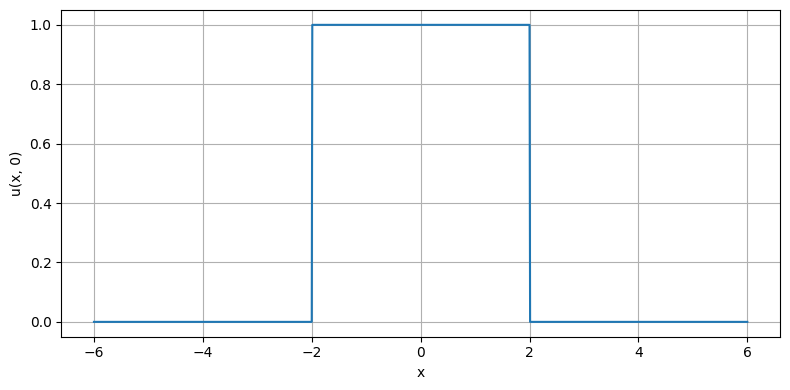

### 1. Finite Volume Method (FVM)


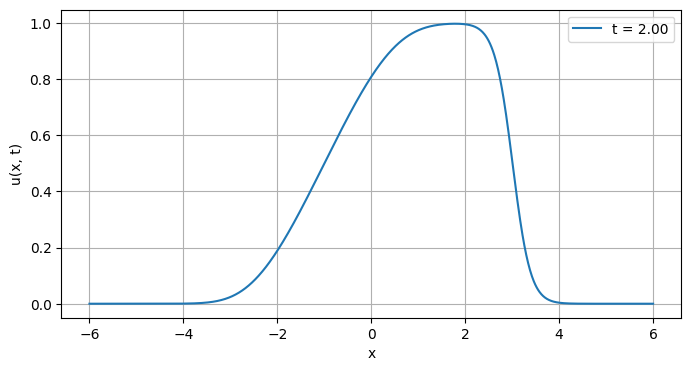

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
mu = 0.1           
CFL = 0.4      
delta_x = 0.01     
nodes = 1200       
t_end = 2.0        

x = np.linspace(-6, 6, nodes + 1)

# Initial Conditions
u = np.zeros(nodes + 1)

u[:((nodes // 3) + 1)] = 0
u[(nodes // 3 + 1) : ((2 * nodes // 3) + 1)] = 1
u[((2 * nodes // 3) + 1) :] = 0

t = 0.0
##

while t < t_end:
    
    u_max = max(np.max(np.abs(u)), mu/delta_x)
    delta_t = CFL * delta_x / u_max

    f = u**2 / 2
    unext = np.copy(u)

    for j in range(1, nodes-2):
        alpha_plus = max(abs(u[j]), abs(u[j + 1]))
        f_hat_plus = 0.5 * (f[j] + f[j + 1]) - 0.5 * alpha_plus * (u[j + 1] - u[j])

        alpha_minus = max(abs(u[j - 1]), abs(u[j]))
        f_hat_minus = 0.5 * (f[j - 1] + f[j]) - 0.5 * alpha_minus * (u[j] - u[j - 1])

        unext[j] = (
            u[j]
            - (delta_t / delta_x) * (f_hat_plus - f_hat_minus)
            + (mu * delta_t / delta_x**2) * (u[j + 1] - 2 * u[j] + u[j - 1])
        )

#Dirichlet Boundary Condition:
    unext[0] = 0.0       
    unext[-1] = 0.0

    u = unext.copy()
    t += delta_t


plt.figure(figsize=(8, 4))
plt.plot(x, u, label=f"t = {t:.2f}")
plt.xlabel("x")
plt.ylabel("u(x, t)")
plt.grid()
plt.legend()
plt.show()


### 2. Physics-Informed Neural Networks (PINNs)


Using device: cuda
Epoch 0, Loss: 0.35752
Epoch 500, Loss: 0.02258
Epoch 1000, Loss: 0.01023
Epoch 1500, Loss: 0.00764
Epoch 2000, Loss: 0.00622
Epoch 2500, Loss: 0.00533
Epoch 3000, Loss: 0.00460
Epoch 3500, Loss: 0.00430
Epoch 4000, Loss: 0.00364
Epoch 4500, Loss: 0.00327
Epoch 5000, Loss: 0.00293
Epoch 5500, Loss: 0.00263
Epoch 6000, Loss: 0.00239
Epoch 6500, Loss: 0.00219
Epoch 7000, Loss: 0.00224
Epoch 7500, Loss: 0.00199
Epoch 8000, Loss: 0.00188
Epoch 8500, Loss: 0.00170
Epoch 9000, Loss: 0.00166
Epoch 9500, Loss: 0.00156
Epoch 10000, Loss: 0.00170
Epoch 10500, Loss: 0.00153
Epoch 11000, Loss: 0.00140
Epoch 11500, Loss: 0.00131
Epoch 12000, Loss: 0.00125
Epoch 12500, Loss: 0.00113
Epoch 13000, Loss: 0.00106
Epoch 13500, Loss: 0.00095
Epoch 14000, Loss: 0.00089
Epoch 14500, Loss: 0.00083


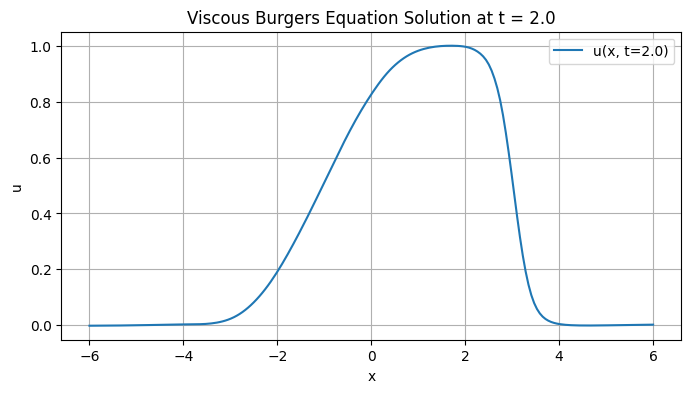

In [13]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

torch.set_default_dtype(torch.float)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.net = nn.Sequential()
        for i in range(len(layers) - 1):
            self.net.add_module(f"layer_{i}", nn.Linear(layers[i], layers[i+1]))
            if i != len(layers) - 2:
                self.net.add_module(f"tanh_{i}", nn.Tanh())

    def forward(self, x, t):
        inputs = torch.cat([x, t], dim=1)
        return self.net(inputs)

def pde_residual(model, x, t, mu):
    x.requires_grad_(True)
    t.requires_grad_(True)
    u = model(x, t)

    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    return u_t + u * u_x - mu * u_xx

#Parameters
mu = 0.1
layers = [2, 64, 64, 64, 1]
model = PINN(layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

#Collocation points (interior of the domain)
N_f = 10000
x_f = torch.FloatTensor(N_f, 1).uniform_(-6, 6).to(device)
t_f = torch.FloatTensor(N_f, 1).uniform_(0, 2).to(device)

#Initial conditions
nodes = 1200
x = np.linspace(-6, 6, nodes + 1)
u = np.zeros(nodes + 1)
u[:((nodes // 3) + 1)] = 0
u[(nodes // 3 + 1) : ((2 * nodes // 3) + 1)] = 1
u[((2 * nodes // 3) + 1) :] = 0

x_ic = torch.tensor(x, dtype=torch.float32).reshape(-1, 1).to(device)
t_ic = torch.zeros_like(x_ic).to(device)
u_ic = torch.tensor(u, dtype=torch.float32).reshape(-1, 1).to(device)


#Boundary conditions
N_bc = 200
t_bc = torch.linspace(0, 2, N_bc).reshape(-1, 1).to(device)
x_bc0 = -6 * torch.ones_like(t_bc)
x_bc1 =  6 * torch.ones_like(t_bc)
u_bc0 = torch.zeros_like(x_bc0)
u_bc1 = torch.zeros_like(x_bc1)

#Training
for epoch in range(15000):
    optimizer.zero_grad()

    #PDE loss (collocation points)
    f = pde_residual(model, x_f, t_f, mu)
    loss_f = torch.mean(f**2)

    #Initial condition loss
    u_pred_ic = model(x_ic, t_ic)
    loss_ic = torch.mean((u_pred_ic - u_ic)**2)

    #Boundary condition loss
    u_pred_bc0 = model(x_bc0, t_bc)
    u_pred_bc1 = model(x_bc1, t_bc)
    loss_bc = torch.mean((u_pred_bc0 - u_bc0)**2) + torch.mean((u_pred_bc1 - u_bc1)**2)

    #Total loss
    loss = loss_f + loss_ic + loss_bc
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.5f}")

#u at t = 5
x_plot = torch.linspace(-6, 6, 200).reshape(-1, 1).to(device)
t_plot = 2.0 * torch.ones_like(x_plot)
u_plot = model(x_plot, t_plot).detach().cpu().numpy()

plt.figure(figsize=(8, 4))
plt.plot(x_plot.cpu().numpy(), u_plot, label='u(x, t=2.0)')
plt.title('Viscous Burgers Equation Solution at t = 2.0')
plt.xlabel('x')
plt.ylabel('u')
plt.grid(True)
plt.legend()
plt.show()

### 3. Error:

In [14]:
error_l2 = np.linalg.norm(u - u_plot) / np.linalg.norm(u)
print(f"L2 Relative Error: {error_l2:.4e}")

L2 Relative Error: 1.5124e+01


## B. Discontinuous Initial Condition 2:

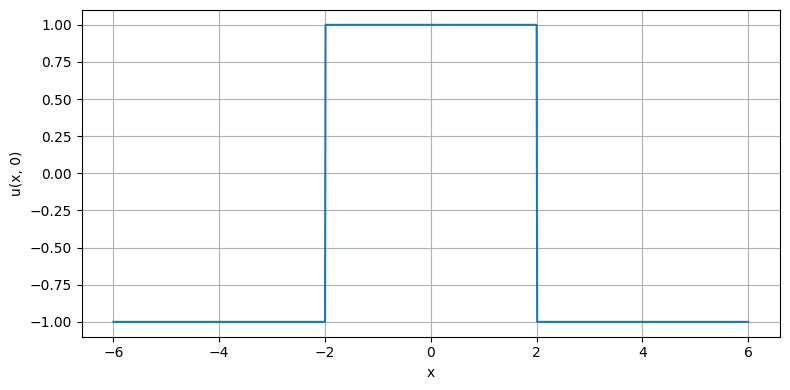

### 1. Finite Volume Method (FVM)

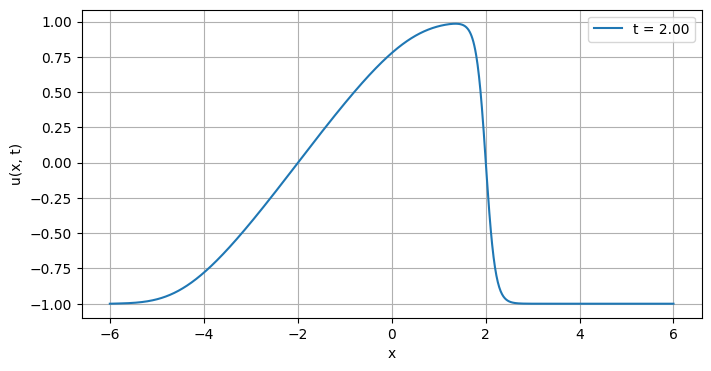

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
mu = 0.1           
CFL = 0.4      
delta_x = 0.01     
nodes = 1200       
t_end = 2.0        

x = np.linspace(-6, 6, nodes + 1)

u = np.zeros(nodes + 1)

u[:((nodes // 3) + 1)] = -1
u[(nodes // 3 + 1) : ((2 * nodes // 3) + 1)] = 1
u[((2 * nodes // 3) + 1) :] = -1

t = 0.0

while t < t_end:
    
    u_max = max(np.max(np.abs(u)), mu/delta_x)
    delta_t = CFL * delta_x / u_max

    f = u**2 / 2
    unext = np.copy(u)

    for j in range(1, nodes-2):
        alpha_plus = max(abs(u[j]), abs(u[j + 1]))
        f_hat_plus = 0.5 * (f[j] + f[j + 1]) - 0.5 * alpha_plus * (u[j + 1] - u[j])

        alpha_minus = max(abs(u[j - 1]), abs(u[j]))
        f_hat_minus = 0.5 * (f[j - 1] + f[j]) - 0.5 * alpha_minus * (u[j] - u[j - 1])

        unext[j] = (
            u[j]
            - (delta_t / delta_x) * (f_hat_plus - f_hat_minus)
            + (mu * delta_t / delta_x**2) * (u[j + 1] - 2 * u[j] + u[j - 1])
        )

#Dirichlet Boundary Condition:
    unext[0] = -1.0       
    unext[-1] = -1.0

    u = unext.copy()
    t += delta_t


plt.figure(figsize=(8, 4))
plt.plot(x, u, label=f"t = {t:.2f}")
plt.xlabel("x")
plt.ylabel("u(x, t)")
plt.grid()
plt.legend()
plt.show()


### 2. Physics-Informed Neural Network

Using device: cuda
Epoch 0, Loss: 2.80024
Epoch 500, Loss: 0.09789
Epoch 1000, Loss: 0.04068
Epoch 1500, Loss: 0.02988
Epoch 2000, Loss: 0.02469
Epoch 2500, Loss: 0.02136
Epoch 3000, Loss: 0.01870
Epoch 3500, Loss: 0.01657
Epoch 4000, Loss: 0.01474
Epoch 4500, Loss: 0.01287
Epoch 5000, Loss: 0.01091
Epoch 5500, Loss: 0.00949
Epoch 6000, Loss: 0.00874
Epoch 6500, Loss: 0.00795
Epoch 7000, Loss: 0.00753
Epoch 7500, Loss: 0.00698
Epoch 8000, Loss: 0.00650
Epoch 8500, Loss: 0.00617
Epoch 9000, Loss: 0.00591
Epoch 9500, Loss: 0.00561
Epoch 10000, Loss: 0.00537
Epoch 10500, Loss: 0.00485
Epoch 11000, Loss: 0.00522
Epoch 11500, Loss: 0.00450
Epoch 12000, Loss: 0.00463
Epoch 12500, Loss: 0.00376
Epoch 13000, Loss: 0.00364
Epoch 13500, Loss: 0.00343
Epoch 14000, Loss: 0.01202
Epoch 14500, Loss: 0.00813


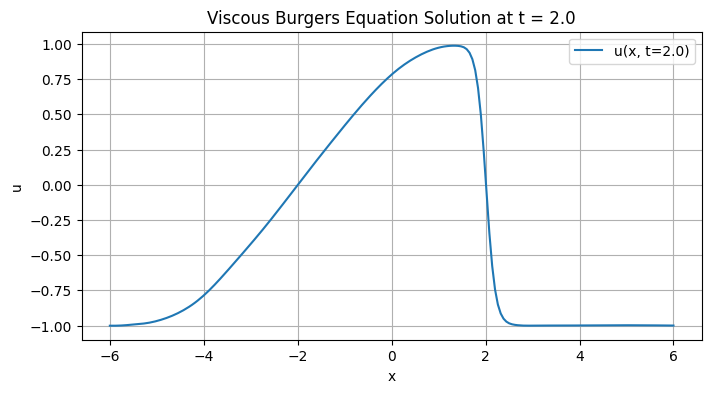

In [11]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

torch.set_default_dtype(torch.float)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.net = nn.Sequential()
        for i in range(len(layers) - 1):
            self.net.add_module(f"layer_{i}", nn.Linear(layers[i], layers[i+1]))
            if i != len(layers) - 2:
                self.net.add_module(f"tanh_{i}", nn.Tanh())

    def forward(self, x, t):
        inputs = torch.cat([x, t], dim=1)
        return self.net(inputs)

def pde_residual(model, x, t, mu):
    x.requires_grad_(True)
    t.requires_grad_(True)
    u = model(x, t)

    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    return u_t + u * u_x - mu * u_xx

#Parameters
mu = 0.1
layers = [2, 64, 128, 64, 1]
model = PINN(layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

#Collocation points (interior of the domain)
N_f = 10000
x_f = torch.FloatTensor(N_f, 1).uniform_(-6, 6).to(device)
t_f = torch.FloatTensor(N_f, 1).uniform_(0, 2).to(device)

#Initial conditions
nodes = 1200
x = np.linspace(-6, 6, nodes + 1)
u = np.zeros(nodes + 1)
u[:((nodes // 3) + 1)] = -1
u[(nodes // 3 + 1) : ((2 * nodes // 3) + 1)] = 1
u[((2 * nodes // 3) + 1) :] = -1

x_ic = torch.tensor(x, dtype=torch.float32).reshape(-1, 1).to(device)
t_ic = torch.zeros_like(x_ic).to(device)
u_ic = torch.tensor(u, dtype=torch.float32).reshape(-1, 1).to(device)


#Boundary conditions
N_bc = 200
t_bc = torch.linspace(0, 2, N_bc).reshape(-1, 1).to(device)
x_bc0 = -6 * torch.ones_like(t_bc)
x_bc1 =  6 * torch.ones_like(t_bc)
u_bc0 = -1 * torch.ones_like(x_bc0)
u_bc1 = -1 * torch.ones_like(x_bc1)

#Training
for epoch in range(15000):
    optimizer.zero_grad()

    #PDE loss (collocation points)
    f = pde_residual(model, x_f, t_f, mu)
    loss_f = torch.mean(f**2)

    #Initial condition loss
    u_pred_ic = model(x_ic, t_ic)
    loss_ic = torch.mean((u_pred_ic - u_ic)**2)

    #Boundary condition loss
    u_pred_bc0 = model(x_bc0, t_bc)
    u_pred_bc1 = model(x_bc1, t_bc)
    loss_bc = torch.mean((u_pred_bc0 - u_bc0)**2) + torch.mean((u_pred_bc1 - u_bc1)**2)

    #Total loss
    loss = loss_f + loss_ic + loss_bc
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.5f}")

#u at t = 5
x_plot = torch.linspace(-6, 6, 200).reshape(-1, 1).to(device)
t_plot = 2.0 * torch.ones_like(x_plot)
u_plot = model(x_plot, t_plot).detach().cpu().numpy()

plt.figure(figsize=(8, 4))
plt.plot(x_plot.cpu().numpy(), u_plot, label='u(x, t=2.0)')
plt.title('Viscous Burgers Equation Solution at t = 2.0')
plt.xlabel('x')
plt.ylabel('u')
plt.grid(True)
plt.legend()
plt.show()


### 3. Error:

In [12]:
error_l2 = np.linalg.norm(u - u_plot) / np.linalg.norm(u)
print(f"L2 Relative Error: {error_l2:.4e}")

L2 Relative Error: 1.7024e+01
